In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 

from sklearn import tree, metrics
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier

from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

%matplotlib inline

vehicle_classifier = pd.read_csv('FIT1043-vehicle-classifier.csv')

## Data wrangling

The number of records and columns of the dataset is observed. Then, the five-number summary is shown as a guide for data wrangling.

In [2]:
#Rough idea of data
print(f'Records: {vehicle_classifier.shape[0]}')
print(f'Columns: {vehicle_classifier.shape[1]}')
vehicle_classifier.head()

Records: 156
Columns: 14


,Manufacturer,Model,Vehicle_class,Vehicle_alt_class,US_vehicle_type,Engine_size (litres),Horsepower,Wheelbase,Width,Length,Height,Curb_weight,Fuel_capacity,Fuel_efficiency
0,Acura,Integra,Coupe,Sports,Passenger,1.8,140,101.2,67.3,172.4,52.6,2.639,13.2,28.0
1,Acura,TL,Sedan,NaN,Passenger,3.2,225,108.1,70.3,192.9,56.1,3.517,17.2,25.0
2,Acura,CL,Coupe,NaN,Passenger,3.2,225,106.9,70.6,192.0,54.7,3.470,17.2,26.0
3,Acura,RL,Sedan,NaN,Passenger,3.5,210,114.6,71.4,196.6,56.5,3.850,18.0,22.0
4,Audi,A4,Sedan,NaN,Passenger,1.8,150,103.0,68.2,178.0,55.7,2.998,16.4,27.0


In [3]:
#observe 5-num summary
vehicle_classifier.describe()

,Engine_size (litres),Horsepower,Wheelbase,Width,Length,Height,Curb_weight,Fuel_capacity,Fuel_efficiency
count,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,155.000000,156.000000,154.000000
mean,3.060897,185.948718,107.499359,71.133974,187.301923,59.187179,3.378026,17.951923,23.844156
std,1.044653,56.700321,7.638996,3.415326,13.402491,7.922412,0.630502,3.887921,4.282706
min,1.000000,55.000000,92.600000,62.600000,149.400000,47.000000,1.895000,10.300000,15.000000
25%,2.300000,149.500000,103.000000,68.500000,177.575000,54.775000,2.971000,15.800000,21.000000
50%,3.000000,177.500000,107.000000,70.550000,187.900000,56.200000,3.342000,17.200000,24.000000
75%,3.575000,215.000000,112.200000,73.175000,196.125000,64.525000,3.799500,19.575000,26.000000
max,8.000000,450.000000,138.700000,79.900000,224.500000,104.500000,5.572000,32.000000,45.000000


The five-number summary shows that there are missing data (as the count are not all 156). Besides, the maximum height shown is 104.5, which is highly unrealistic. As we have sufficient information on what the specific car is, a simple search is done to obtain its actual value and replace it with the wrong value. The record is not deleted, or filled in with mean values as this might compromise the accuracy of the data analysis further on. A similar approach is used on vehicles with missing numerical feature values.

In [4]:
#display vehicles with height > 90
vehicle_classifier[vehicle_classifier['Height']>90]

,Manufacturer,Model,Vehicle_class,Vehicle_alt_class,US_vehicle_type,Engine_size (litres),Horsepower,Wheelbase,Width,Length,Height,Curb_weight,Fuel_capacity,Fuel_efficiency
24,Chevrolet,Corvette,Coupe,Sports,Passenger,5.7,345,104.5,73.6,179.7,104.5,3.21,19.1,22.0


There is only one car that has a highly unrealistic height, looking at this car, the height is the exact same as its wheelbase, further confirming this is a data entry error. The actual height of the car is obtained from <a href="https://books.google.com.my/books?id=99hqlCxuXKEC&lpg=PA309&ots=KvLXQlchPK&dq=Chevrolet%20Corvette%20Coupe%2073.6%09179.7%09104.5&pg=PA307#v=onepage&q=Chevrolet%20Corvette%20Coupe%2073.6%09179.7%09104.5&f=false">The Complete Book of Corvette: Every Model Since 1953</a>. 



In [5]:
#replace with real height
vehicle_classifier['Height'].replace({104.5:47.7},inplace=True)

## Investigating NaN Values

In [6]:
nan_cols = [i for i in vehicle_classifier.columns if vehicle_classifier[i].isnull().any()]
print(f'Columns containing NaN values are: {nan_cols}')

Columns containing NaN values are: ['Vehicle_alt_class', 'Curb_weight', 'Fuel_efficiency']


``Vehicle_alt_class`` serves as an alternative classification for more detailed classification. We will directly copy the value from ``Vehicle_class`` to the respective empty rows in ``Vehicle_alt_class`` because it is the most suitable column for identifying. 

In [7]:
#fill empty cells with values from Vehicle_class
vehicle_classifier.loc[vehicle_classifier['Vehicle_alt_class'].isnull(),'Vehicle_alt_class'] = vehicle_classifier['Vehicle_class']

In [8]:
#Curb_weight and Fuel_efficiency
vehicle_classifier[vehicle_classifier.isnull().any(axis=1)] 

,Manufacturer,Model,Vehicle_class,Vehicle_alt_class,US_vehicle_type,Engine_size (litres),Horsepower,Wheelbase,Width,Length,Height,Curb_weight,Fuel_capacity,Fuel_efficiency
15,Cadillac,Seville,Sedan,Sedan,Passenger,4.6,275,112.2,75.0,201.0,55.4,NaN,18.5,22.0
37,Dodge,Intrepid,Sedan,Sedan,Passenger,2.7,202,113.0,74.7,203.7,55.9,3.489,17.0,NaN
108,Oldsmobile,Intrigue,Sedan,Sedan,Passenger,3.5,215,109.0,73.6,195.9,56.6,3.455,18.0,NaN


A manual research is done to obtain actual values and fill them in the empty cell. This is to ensure the data analysis will be more accurate. 

- Record #15 has missing value for ``curb weight``
- Record #37 and #108 have missing values for ``Fuel_efficiency``

Reference for curb weight: 
- <a href="https://www.autoblog.com/buy/2004-Cadillac-DeVille-DHS__4dr_Sedan/specs/">DHS 4dr Sedan</a>

Reference for fuel efficiency:
- <a href="https://www.fueleconomy.gov/feg/noframes/15996.shtml">2000 Dodge Intrepid</a>
- <a href="https://www.officialdata.org/cars/Oldsmobile/Intrigue">Oldsmobile Intrigue Information</a>

In [9]:
# Curb_weight
vehicle_classifier.iat[15,11] = 4.049
#Fuel_efficiency
vehicle_classifier.iat[37,13] = 21.0
vehicle_classifier.iat[108,13] = 21.0

In [10]:
#re-observe 5-num sum
vehicle_classifier.describe()

,Engine_size (litres),Horsepower,Wheelbase,Width,Length,Height,Curb_weight,Fuel_capacity,Fuel_efficiency
count,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000
mean,3.060897,185.948718,107.499359,71.133974,187.301923,58.823077,3.382327,17.951923,23.807692
std,1.044653,56.700321,7.638996,3.415326,13.402491,7.087716,0.630756,3.887921,4.267076
min,1.000000,55.000000,92.600000,62.600000,149.400000,47.000000,1.895000,10.300000,15.000000
25%,2.300000,149.500000,103.000000,68.500000,177.575000,54.700000,2.973000,15.800000,21.000000
50%,3.000000,177.500000,107.000000,70.550000,187.900000,56.150000,3.355000,17.200000,24.000000
75%,3.575000,215.000000,112.200000,73.175000,196.125000,63.950000,3.821500,19.575000,26.000000
max,8.000000,450.000000,138.700000,79.900000,224.500000,83.600000,5.572000,32.000000,45.000000


Data wrangling is completed, and the new five-number summary looks acceptable. 

---

# 2. Clustering


## Unsupervised Machine Learning
Unsupervised learning refers to a type of machine learning algorithm that infers patterns from a dataset without using any labelled data as reference. Although the output data is undetermined before clustering, clustering can still help to discover the underlying structure of data. Therefore, we can say that unsupervised machine learning is important to search for patterns that are previously unknown in the dataset.

For unsupervised machine learning in this assignment, we will specifically look at **clustering**, which is a popular application of unsupervised machine learning technique. By clustering the different vehicles in ``vehicle_classifier`` into similar groups based on certain feature values, we can analayse and identify patterns shown by the vehicles.


In [11]:
#2a. clean dataframe for clustering
df = vehicle_classifier.copy()
df.drop(['Vehicle_class','Vehicle_alt_class','US_vehicle_type'],axis=1,inplace=True)
print(df.shape)
df.head()

(156, 11)


,Manufacturer,Model,Engine_size (litres),Horsepower,Wheelbase,Width,Length,Height,Curb_weight,Fuel_capacity,Fuel_efficiency
0,Acura,Integra,1.8,140,101.2,67.3,172.4,52.6,2.639,13.2,28.0
1,Acura,TL,3.2,225,108.1,70.3,192.9,56.1,3.517,17.2,25.0
2,Acura,CL,3.2,225,106.9,70.6,192.0,54.7,3.470,17.2,26.0
3,Acura,RL,3.5,210,114.6,71.4,196.6,56.5,3.850,18.0,22.0
4,Audi,A4,1.8,150,103.0,68.2,178.0,55.7,2.998,16.4,27.0


### Choosing appropriate inputs

To choose the best possible inputs, we will use ``pairplot`` from seaborn libary to have a rough idea of all possible 2d comparison, then select the one with distinct groups for further clustering.


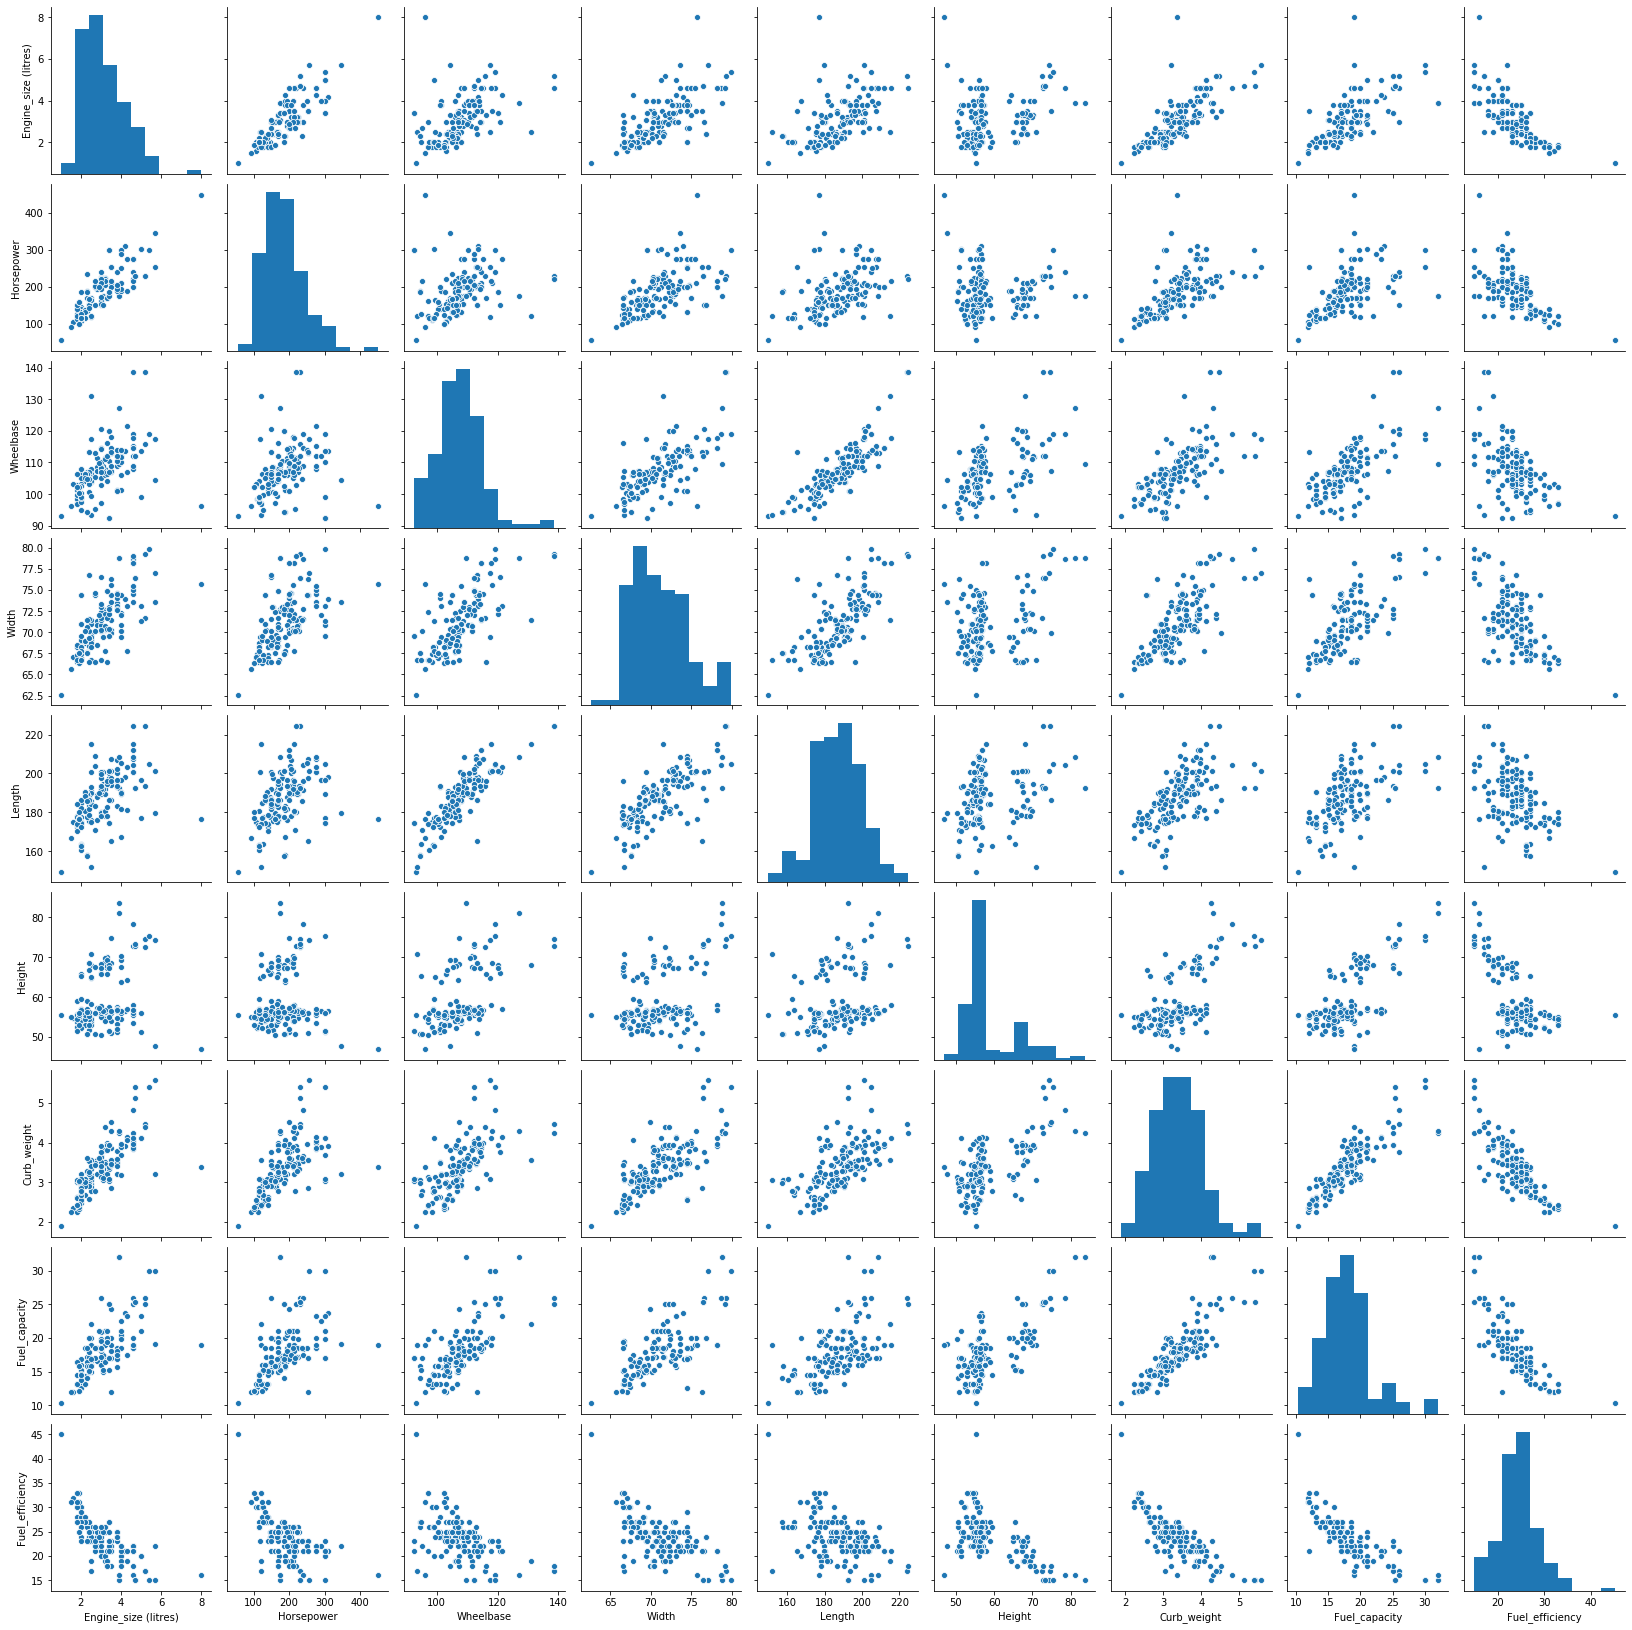

In [12]:
sns.pairplot(df) #might take a while to laod!

It can be seen that graphs with ``Height`` have distinct groups, this shows that vehicles with different heights can be segregated into different groups. We will further look at how different heights of vehicles correlate to the engine size.

Text(0.5, 1.0, 'Height against Engine_size (litres)')

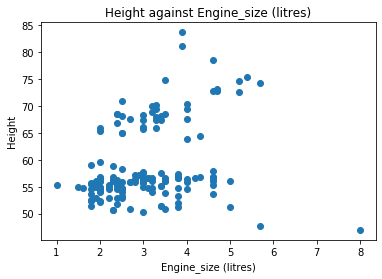

In [13]:
#Visualise Engine_size vs Height

a = 'Engine_size (litres)'
b = 'Height'

plt.scatter(x=df[a], y=df[b])
plt.xlabel(a)
plt.ylabel(b)
plt.title(f'{b} against {a}')

### Setting different k-values
Before visualising the clusters, we will have to determine how many clusters to be generated. 3 different k values (2,5 and 7) are used to build 3 models for comparison.

In [14]:
#k-means
kmeans_n2 = KMeans(n_clusters=2).fit(df[[a,b]])

#cluster centres coordinates
for i in range(len(kmeans_n2.cluster_centers_)):
    print(f'Cluster {i+1}: {tuple(kmeans_n2.cluster_centers_[i])}')
    
#look at the outputs: Cluster labels
print(f'Cluster labels: {list(kmeans_n2.labels_)}')



Cluster 1: (3.52, 69.7775)
Cluster 2: (2.902586206896552, 55.04568965517242)
Cluster labels: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [15]:
#k-means
kmeans_n5 = KMeans(n_clusters=5).fit(df[[a,b]])

#cluster centres coordinates
for i in range(len(kmeans_n5.cluster_centers_)):
    print(f'Cluster {i+1}: {tuple(kmeans_n5.cluster_centers_[i])}')
    
#look at the outputs: Cluster labels
print(f'Cluster labels: {list(kmeans_n5.labels_)}')



Cluster 1: (2.847777777777778, 56.013333333333335)
Cluster 2: (4.55, 73.15)
Cluster 3: (3.0923076923076924, 51.69615384615385)
Cluster 4: (3.0703703703703704, 67.27777777777777)
Cluster 5: (4.133333333333333, 81.03333333333333)
Cluster labels: [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 2, 0, 0, 0, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 1, 4, 4, 3, 1, 3, 2, 2, 0, 0, 0, 0, 3, 3, 4, 3, 1, 0, 0, 3, 3, 3, 0, 0, 0, 0, 0, 1, 3, 3, 0, 0, 0, 0, 1, 3, 0, 0, 1, 2, 2, 0, 0, 2, 1, 3, 0, 2, 0, 0, 1, 3, 0, 0, 0, 2, 2, 2, 0, 0, 3, 0, 0, 0, 3, 3, 3, 3, 0, 0, 0, 0, 3, 3, 0, 0, 3, 2, 2, 0, 2, 0, 0, 3, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 3, 0, 0, 0, 2, 3, 3, 3, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [16]:
#k-means
kmeans_n7 = KMeans(n_clusters=7).fit(df[[a,b]])

#cluster centres coordinates
for i in range(len(kmeans_n7.cluster_centers_)):
    print(f'Cluster {i+1}: {tuple(kmeans_n7.cluster_centers_[i])}')
    
#look at the outputs: Cluster labels
print(f'Cluster labels: {list(kmeans_n7.labels_)}')



Cluster 1: (4.875, 73.7875)
Cluster 2: (3.05, 56.61833333333333)
Cluster 3: (3.1789473684210527, 68.6157894736842)
Cluster 4: (3.65, 50.62857142857143)
Cluster 5: (4.133333333333333, 81.03333333333333)
Cluster 6: (2.442857142857143, 54.27142857142857)
Cluster 7: (2.9, 65.4)
Cluster labels: [5, 1, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 1, 0, 5, 1, 5, 5, 3, 3, 5, 5, 1, 5, 5, 1, 5, 1, 1, 1, 5, 5, 1, 3, 0, 4, 4, 2, 0, 2, 5, 5, 5, 1, 1, 1, 2, 6, 4, 6, 0, 5, 1, 6, 2, 2, 5, 5, 5, 1, 1, 2, 6, 2, 5, 1, 1, 1, 0, 6, 1, 1, 0, 5, 3, 1, 5, 3, 0, 2, 5, 5, 1, 1, 2, 2, 1, 1, 1, 3, 3, 3, 5, 1, 2, 5, 1, 1, 2, 2, 2, 6, 1, 1, 5, 5, 6, 2, 1, 5, 2, 3, 5, 5, 3, 5, 1, 2, 3, 3, 3, 1, 1, 5, 5, 5, 5, 5, 1, 6, 5, 5, 1, 3, 6, 2, 6, 2, 0, 1, 1, 1, 1, 1, 1, 5, 1, 5, 1, 1, 1]


### Clustering visualisation

Now that all 3 clustering models are determined, 3 graphs will be plotted respectively to be compared and analysed.

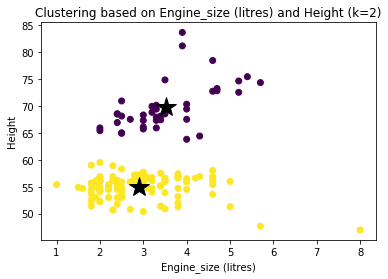

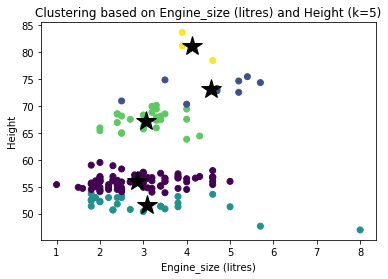

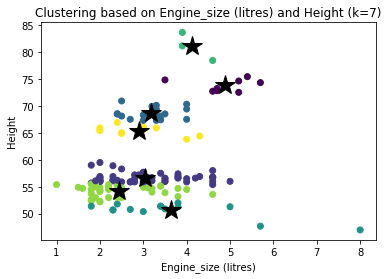

In [17]:
#Visualise the output labels

### n=2
plt.scatter(
    x = df[a],
    y = df[b],
    c = kmeans_n2.labels_)

# Visualise the cluster centers (black stars)
plt.plot(
    kmeans_n2.cluster_centers_[:, 0],
    kmeans_n2.cluster_centers_[:,1],
    'k*',
    markersize = 20
)

plt.xlabel(a)
plt.ylabel(b)
plt.title(f'Clustering based on {a} and {b} (k=2)')
plt.show()


plt.figure()
### n=5
#Visualise the output labels
plt.scatter(
    x = df[a],
    y = df[b],
    c = kmeans_n5.labels_)

# Visualise the cluster centers (black stars)
plt.plot(
    kmeans_n5.cluster_centers_[:, 0],
    kmeans_n5.cluster_centers_[:,1],
    'k*',
    markersize = 20
)

plt.xlabel(a)
plt.ylabel(b)
plt.title(f'Clustering based on {a} and {b} (k=5)')
plt.show()

plt.figure()
### n=7
#Visualise the output labels
plt.scatter(
    x = df[a],
    y = df[b],
    c = kmeans_n7.labels_)

# Visualise the cluster centers (black stars)
plt.plot(
    kmeans_n7.cluster_centers_[:, 0],
    kmeans_n7.cluster_centers_[:,1],
    'k*',
    markersize = 20
)

plt.xlabel(a)
plt.ylabel(b)
plt.title(f'Clustering based on {a} and {b} (k=7)')
plt.show()

### Clustering analysis

Based on the graph for k=2, there are two clear distinct groups, where one has a smaller height (below 60), and the other has taller height (above 65). We can assume that there are two distinct types of vehicles, vehicles that are shorter, and vehicles that are taller. 

For shorter vehicles, the engine size is more widely distributed, becuase there are engine sizes from 1l to 8l. On the other hand, vehicles with taller height have a smaller range of engine size. This tells us that tall vehicles more or less share similar engine size, but shorter vehicles will have varying engine sizes.

k=5 provides not much meaningful or important insight, however looking at n=7, the bottom group that has a really low height have highly varying engine sizes. Looking at the ones with very large engine size, this might point to vehicles that are specially designed, or customised, such as fancy sports cars. 

The first clustering attempt only shows us that there are two distinct groups of vehicles, which are shorter vehicles and taller vehicles, and that shorter vehicles have wider range of engine size. To find out if there are more underlying pattern, and to make k=5 and k=7 more meaningful, we will try to modify ``Engine_size (litres)`` by creating a new column of power output for it.


## Improving the clustering

A new column containing the power output of vehicles is made by dividing ``Horsepower`` with ``Engine_size (litres)``. This column will then be compared to ``Height`` for clustering. Additionally, we will be switching the axes such that ``Height`` becomes the x-axis. This is to provide a different perspective ad view the magnitude of power output easily by placing it at the y-axis.

In [18]:
#new column (power output)
df['Power output per litre (hp/l)'] = df['Horsepower']/df['Engine_size (litres)']

Text(0.5, 1.0, 'Power output per litre (hp/l) against Height')

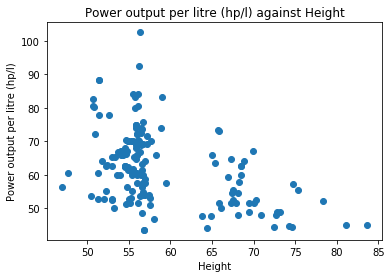

In [19]:
#Visualise 
a = 'Height'
b = 'Power output per litre (hp/l)'


plt.scatter(x=df[a], y=df[b])
plt.xlabel(a)
plt.ylabel(b)
plt.title(f'{b} against {a}')

### Setting different k-values
Before visualising the clusters, we will have to determine how many clusters to be generated. 3 different k values (2,5 and 7) are used to build 3 models for comparison.

In [20]:
#k-means
kmeans_n2 = KMeans(n_clusters=2, init='random').fit(df[[a,b]])

#cluster centres coordinates
for i in range(len(kmeans_n2.cluster_centers_)):
    print(f'Cluster {i+1}: {tuple(kmeans_n2.cluster_centers_[i])}')
    
#look at the outputs: Cluster labels
print(f'Cluster labels: {list(kmeans_n2.labels_)}')



Cluster 1: (62.09620253164557, 53.74442885741989)
Cluster 2: (55.46493506493507, 71.02107061356753)
Cluster labels: [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1]


In [21]:
#k-means
kmeans_n5 = KMeans(n_clusters=5).fit(df[[a,b]])

#cluster centres coordinates
for i in range(len(kmeans_n5.cluster_centers_)):
    print(f'Cluster {i+1}: {tuple(kmeans_n5.cluster_centers_[i])}')
    
#look at the outputs: Cluster labels
print(f'Cluster labels: {list(kmeans_n5.labels_)}')



Cluster 1: (55.28727272727273, 68.01401390558826)
Cluster 2: (70.8, 49.803700446037205)
Cluster 3: (55.106521739130436, 55.206596008042105)
Cluster 4: (67.39166666666667, 64.46527777777777)
Cluster 5: (53.973333333333336, 84.40474599874699)
Cluster labels: [4, 0, 0, 2, 4, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 2, 2, 0, 1, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 1, 1, 3, 2, 2, 0, 2, 2, 2, 1, 1, 1, 1, 1, 0, 2, 3, 3, 3, 2, 0, 0, 0, 4, 1, 1, 1, 0, 0, 0, 0, 1, 3, 2, 2, 1, 0, 0, 2, 2, 2, 1, 3, 0, 0, 2, 2, 1, 1, 4, 0, 0, 2, 4, 4, 0, 2, 3, 0, 0, 0, 1, 1, 1, 1, 2, 2, 0, 0, 1, 1, 0, 0, 3, 0, 0, 2, 2, 2, 2, 1, 4, 4, 4, 0, 4, 2, 2, 0, 0, 0, 0, 3, 0, 2, 0, 4, 3, 3, 3, 1, 1, 2, 2, 4, 2, 2, 2, 4, 4, 0, 0, 4, 0]


In [22]:
#k-means
kmeans_n7 = KMeans(n_clusters=7).fit(df[[a,b]])

#cluster centres coordinates
for i in range(len(kmeans_n7.cluster_centers_)):
    print(f'Cluster {i+1}: {tuple(kmeans_n7.cluster_centers_[i])}')
    
#look at the outputs: Cluster labels
print(f'Cluster labels: {list(kmeans_n7.labels_)}')



Cluster 1: (55.6825, 69.82548706771301)
Cluster 2: (75.91111111111111, 46.75714563732481)
Cluster 3: (54.71081081081081, 60.73486560903778)
Cluster 4: (53.973333333333336, 84.40474599874699)
Cluster 5: (68.375, 51.56779842098926)
Cluster 6: (67.30909090909091, 65.08333333333333)
Cluster 7: (55.170833333333334, 51.66936128893221)
Cluster labels: [3, 0, 0, 2, 3, 0, 0, 0, 0, 0, 2, 2, 6, 6, 2, 2, 2, 0, 1, 6, 6, 2, 6, 6, 2, 0, 6, 6, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 1, 1, 1, 4, 1, 5, 6, 6, 0, 6, 6, 6, 4, 4, 1, 4, 1, 0, 2, 5, 5, 5, 2, 0, 2, 0, 3, 4, 4, 4, 0, 0, 0, 0, 1, 5, 2, 6, 4, 2, 2, 2, 2, 6, 4, 4, 2, 2, 6, 6, 4, 4, 3, 0, 2, 2, 3, 3, 0, 2, 5, 0, 2, 0, 4, 4, 4, 4, 6, 2, 2, 2, 4, 4, 0, 0, 5, 0, 2, 6, 6, 6, 6, 4, 3, 3, 3, 0, 3, 6, 6, 0, 2, 2, 0, 5, 0, 2, 0, 3, 5, 5, 5, 4, 1, 2, 2, 3, 2, 2, 2, 3, 3, 0, 0, 3, 0]


### Clustering visualisation

Now that all 3 clustering models are determined, 3 graphs will be plotted respectively to be compared and analysed.

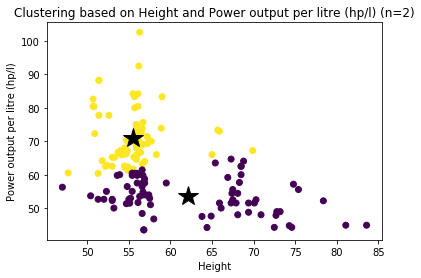

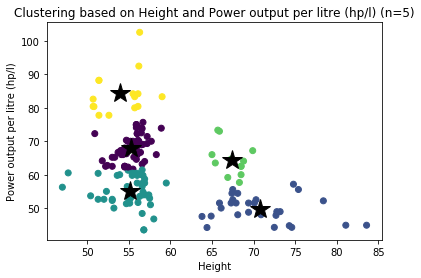

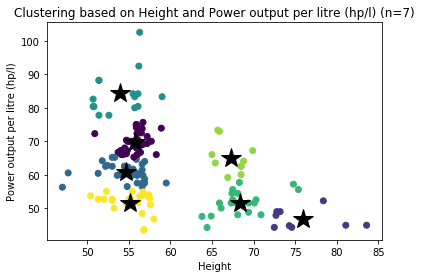

In [23]:
#Visualise the output labels

### n=2
plt.scatter(
    x = df[a],
    y = df[b],
    c = kmeans_n2.labels_)

# Visualise the cluster centers (black stars)
plt.plot(
    kmeans_n2.cluster_centers_[:, 0],
    kmeans_n2.cluster_centers_[:,1],
    'k*',
    markersize = 20
)

plt.xlabel(a)
plt.ylabel(b)
plt.title(f'Clustering based on {a} and {b} (n=2)')
plt.show()


plt.figure()
### n=5
#Visualise the output labels
plt.scatter(
    x = df[a],
    y = df[b],
    c = kmeans_n5.labels_)

# Visualise the cluster centers (black stars)
plt.plot(
    kmeans_n5.cluster_centers_[:, 0],
    kmeans_n5.cluster_centers_[:,1],
    'k*',
    markersize = 20
)

plt.xlabel(a)
plt.ylabel(b)
plt.title(f'Clustering based on {a} and {b} (n=5)')
plt.show()

plt.figure()
### n=7
#Visualise the output labels
plt.scatter(
    x = df[a],
    y = df[b],
    c = kmeans_n7.labels_)

# Visualise the cluster centers (black stars)
plt.plot(
    kmeans_n7.cluster_centers_[:, 0],
    kmeans_n7.cluster_centers_[:,1],
    'k*',
    markersize = 20
)

plt.xlabel(a)
plt.ylabel(b)
plt.title(f'Clustering based on {a} and {b} (n=7)')
plt.show()

### Clustering analysis

For the improved version, we can see that k=2 is no longer the most insightful graph. We will only look at k=5 and k=7 to extract insight and patterns.

Looking at k=5 and k=7, we can see that shorter vehicles (height: 50-60) have varying power output. For the first clutering attempt, we only see 1 outlier with a short height but large engine size, which is hard to confirm that it is a valid group. However, the improved clustering shows a distinct group with more number of vehicles that are short, but have a high power output. From this, we know that there is a number of vehicles that are designed to be short, but still have high power output.

Overall, we can say that shorter vehicles can be divided into different groups based on their power output, and the power output might be quite different from one another (might be very high, or very low). However, for taller vehicles, the power output mostly remains under 70hp/l. 


---

# 3. Classification

## Binary and Multi-class classification
Both binary and multi-class classification are supervised machine learning technique. The difference is binary classification only takes **two** categorical values as the target variable for classification. On the other hand, multi-class classification can take on **more than two** classes as the target variable.

## Supervised machine learning
Supervised machine learning is the algorithm that trains the machine using data such that the outcome is already determined. In other words, supervised learning uses **labelled data** (data that have been tagged with labels) to predict outcomes for unforeseen or newly-introduced data.

To conduct supervised learning, the dataset is split into two subsets, which are **training set** and **test set**. Training set is used to train the model, while test set is used to test the trained model afterwards. The ratio of slicing a dataset into training set and test set is determined by how statistically meaningful the results can be. 


## Binary classification (decision tree algorithm)
labelled data = ``US_vehicle_type``

In [24]:
#data frame used for classification
df2 = vehicle_classifier.copy()
print(df2.shape)
df2.head()

(156, 14)


,Manufacturer,Model,Vehicle_class,Vehicle_alt_class,US_vehicle_type,Engine_size (litres),Horsepower,Wheelbase,Width,Length,Height,Curb_weight,Fuel_capacity,Fuel_efficiency
0,Acura,Integra,Coupe,Sports,Passenger,1.8,140,101.2,67.3,172.4,52.6,2.639,13.2,28.0
1,Acura,TL,Sedan,Sedan,Passenger,3.2,225,108.1,70.3,192.9,56.1,3.517,17.2,25.0
2,Acura,CL,Coupe,Coupe,Passenger,3.2,225,106.9,70.6,192.0,54.7,3.470,17.2,26.0
3,Acura,RL,Sedan,Sedan,Passenger,3.5,210,114.6,71.4,196.6,56.5,3.850,18.0,22.0
4,Audi,A4,Sedan,Sedan,Passenger,1.8,150,103.0,68.2,178.0,55.7,2.998,16.4,27.0


In [25]:
#check the labelled data
df2['US_vehicle_type'].value_counts()

Passenger    116
Car           40
Name: US_vehicle_type, dtype: int64

For visualisation in the later part, we will make 'Passenger' = 0 and 'Car' = 1

In [26]:
#Replace 'Passenger' with 0 and 'Car' with '1'
temp = df2['US_vehicle_type'].unique().tolist()
mapping = dict(zip(temp,range(len(temp))))
df2.replace({'US_vehicle_type':mapping},inplace=True)
df2['US_vehicle_type'].value_counts()

0    116
1     40
Name: US_vehicle_type, dtype: int64

In [27]:
x = df2.iloc[:,[10,12]].values #input data: Height, Fuel_capacity
y = df2.iloc[:,4].values #labelled data: US_vehicle_type

x_train, x_test, y_train, y_test = train_test_split(x,y,
                                                   test_size = 0.2, 
                                                   random_state = 0)

In [28]:
#Feature scaling
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [29]:
#Train and Test using Decision Tree algorithm

classifier1 = DecisionTreeClassifier(criterion='entropy',
                                   random_state=0)

#Fitting Decision Tree Classification to the Training Set
classifier1.fit(x_train,y_train)
        

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

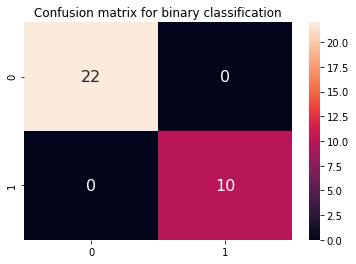

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      1.00      1.00        10

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32

The accuracy score is 100.0%


In [30]:
#Predicting the Test set results
y_pred = classifier1.predict(x_test)

#Confusion Matrix (compare y_pred to actual y_test)
cm = confusion_matrix(y_test,y_pred)

#cm visualisation
sns.heatmap(cm, annot=True, annot_kws={"size": 16}) # font size
plt.title('Confusion matrix for binary classification')
plt.show()

#Show classification report
print(metrics.classification_report(y_test, y_pred))
accuracy = accuracy_score(y_test,y_pred)
print(f'The accuracy score is {accuracy*100}%')

### Binary class visualisation

The confusion matrix is visualised using meshgrid.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


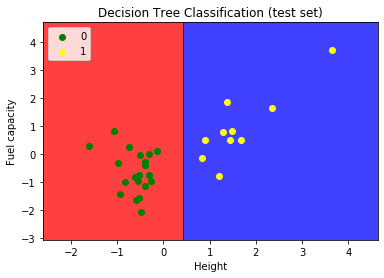

In [31]:
# Visualising the Test set Results


x_set, y_set = x_test, y_test

x1, x2 = np.meshgrid(np.arange(
                    start = x_set[:,0].min()-1,
                    stop = x_set[:,0].max()+1,
                    step = 0.01
                    ),
                    np.arange(
                    start = x_set[:,1].min()-1,
                    stop = x_set[:,1].max()+1,
                    step = 0.01)
                    )

plt.contourf(x1,x2,classifier1.predict(np.array
                                     ([x1.ravel(),x2.ravel()]).T).reshape(x1.shape),
                                       alpha=0.75,
                                       cmap=ListedColormap(('red','blue'))
            )

plt.xlim(x1.min(),x1.max())
plt.ylim(x2.min(),x2.max())

for i,j in enumerate(np.unique(y_set)):
    plt.scatter(
    x_set[y_set == j, 0],
    x_set[y_set == j, 1],
    c = ListedColormap(('green','yellow'))(i),
    label = j)
    
plt.title('Decision Tree Classification (test set)')
plt.xlabel('Height')
plt.ylabel('Fuel capacity')
plt.legend()

plt.show()

### Evaluation (based on meshgrid and confusion matrix)

The graph shows that all data has been predicted correctly, as the green dots (Passenger) are all in the shorter height red region; while the yellow dots (Car) are all in the taller height blue region.

Therefore, the accuracy score is 100% and we know that using Height is a very efficient and suitable way to carry out the binary classification of vehicles.

In [32]:
#3f. Output to csv
prediction_csv = pd.DataFrame(y_pred, columns=['predictions'])
prediction_csv.index += 1
prediction_csv.to_csv('3c.binary_classification_prediction.csv', index_label='id')

## Multi-class classification (decision tree algorithm)
labelled data = ``vehicle_class``

In [33]:
x = df2.iloc[:,[5,6,7,8,9,10,11,12,13]].values #input data:all numerical feature data
y = df2.iloc[:,2].values #labelled data: vehicle_class

x_train, x_test, y_train, y_test = train_test_split(x,y,
                                                    test_size=0.2,  
                                                   random_state=0)

In [34]:
#Feature scaling
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

#Train and Test using Decision Tree algorithm
classifier2 = DecisionTreeClassifier(criterion='entropy',
                                   random_state=0,
                                    max_depth=4)

#Fitting Decision Tree Classification to the Training Set
classifier2.fit(x_train,y_train)

#Predicting the Test set results
y_pred = classifier2.predict(x_test)


### Multi-class classifcation visualisation 
The classification that uses ``Vehicle_class`` as labelled data is visualised by plotting a tree.

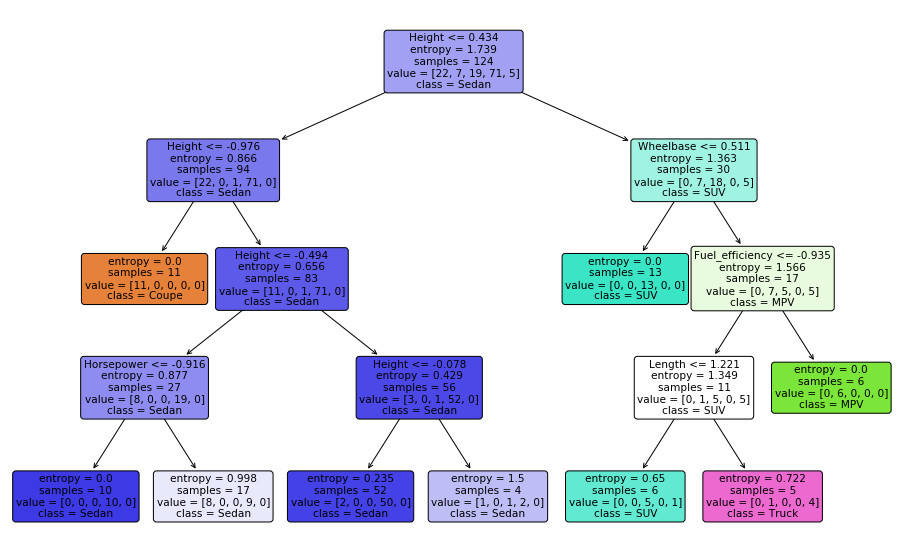

In [35]:
#Visualising decision tree
feature_name = df2.columns[5:14]
class_name = ['Coupe','MPV','SUV','Sedan','Truck']

plt.figure(figsize=(16,10))
tree.plot_tree(classifier2,
              max_depth =None,
              feature_names=feature_name,
              class_names=class_name,
              filled=True,
              rounded=True,
              fontsize=10.5);


### Confusion matrix

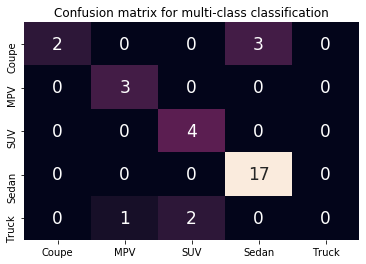

              precision    recall  f1-score   support

       Coupe       1.00      0.40      0.57         5
         MPV       0.75      1.00      0.86         3
         SUV       0.67      1.00      0.80         4
       Sedan       0.85      1.00      0.92        17
       Truck       0.00      0.00      0.00         3

    accuracy                           0.81        32
   macro avg       0.65      0.68      0.63        32
weighted avg       0.76      0.81      0.76        32

The accuracy score is 81.25%


C:\Users\jiaxin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [36]:
#Making the confusion matrix
cm = confusion_matrix(y_test, y_pred)

#Visualise cm
sns.heatmap(cm, 
            annot=True, 
            annot_kws={"size": 17},
            cbar=False,
            xticklabels=['Coupe','MPV','SUV','Sedan','Truck'],
            yticklabels=['Coupe','MPV','SUV','Sedan','Truck']) # font size

plt.title('Confusion matrix for multi-class classification')
plt.show()


print(classification_report(y_test,y_pred))
accuracy = accuracy_score(y_test,y_pred)
print(f'The accuracy score is {round(accuracy*100,2)}%')

### Evaluation (based on decision tree visualisation and confusion matrix)

Based on the confusion matrix, it shows that there are 6 wrongfully predicted data.
The wrongfully predicted data are as follows:

In [37]:
#print wrong predictions
merge = list(zip(y_pred,y_test))
idx_counter = 0
idx = []
for elem in merge:
    if elem[0] != elem[1]:
        idx.append(idx_counter)
        print(f'index: {idx_counter}')
        print(f'Actual: {elem[1]}; Predicted: {elem[0]}')
    idx_counter += 1


index: 1
Actual: Truck; Predicted: MPV
index: 7
Actual: Coupe; Predicted: Sedan
index: 9
Actual: Truck; Predicted: SUV
index: 13
Actual: Coupe; Predicted: Sedan
index: 22
Actual: Truck; Predicted: SUV
index: 30
Actual: Coupe; Predicted: Sedan


According to the confusion matrix, no trucks were predicted correctly. Two of the trucks were mistaken as SUV; and the other one was mistaken as MPV. Referring back to the decision tree visualisation, we know the algorithm decides on Truck based on the height, wheelbase, fuel efficiency and length. The preceeding columns of Truck were MPV and SUV, which might explain the inability of the algorithm the predict the trucks as they share somewhat similar values, and there weren't enough distinct truck data to be trained with.

The other three incorrect predictions were when the model predicted Sedan for actual Coupe. Referring to the decision tree visualisation, this can be seen at the left part of the graph. The similarity in height has made the algorithm wrongfully predicted Coupe as Sedan.

Overall, the model works fine, as the classifcation report shows an accuracy score of 81.25%. 

In [38]:
#3f. Output to csv
prediction_csv = pd.DataFrame(y_pred, columns=['predictions'])
prediction_csv.index += 1
prediction_csv.to_csv('3d.multi_classification_prediction.csv', index_label='id')

## Multi-class classification 2 (decision tree algorithm) 
labelled data = ``Vehicle_alt_class``

In [39]:
x = df2.iloc[:,[6,10,13]].values #all numbered data
y = df2.iloc[:,3].values #labelled data: vehicle_alt_class

x_train, x_test, y_train, y_test = train_test_split(x,y,
                                                    test_size=0.2,  
                                                   random_state=0)

In [40]:
#Feature scaling
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

#Train and Test using Decision Tree algorithm
classifier3 = DecisionTreeClassifier(criterion='entropy',
                                   random_state=0,
                                    max_depth=3)

#Fitting Decision Tree Classification to the Training Set
classifier3.fit(x_train,y_train)

#Predicting the Test set results
y_pred = classifier3.predict(x_test)

### Multi-class classifcation 2 visualisation 
The classification that uses ``Vehicle_alt_class`` as labelled data is visualised by plotting a tree.

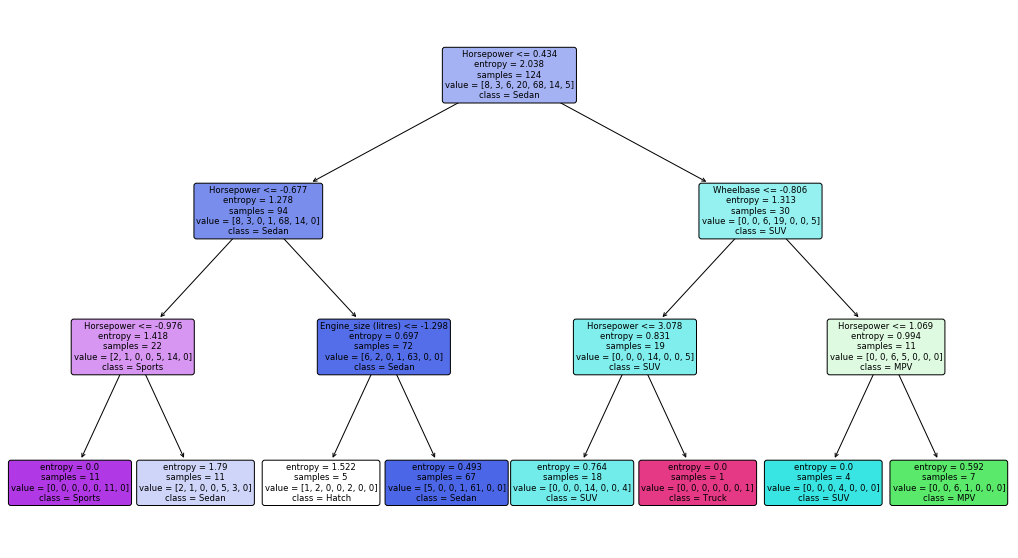

In [41]:
feature_name = df2.columns[5:14]
class_name = ['Coupe','Hatch','MPV','SUV','Sedan','Sports','Truck']


plt.figure(figsize=(18,10))
tree.plot_tree(classifier3,
               max_depth=None,
              feature_names=feature_name,
              class_names=class_name,
              filled=True,
              rounded=True,
               fontsize=8.5
              );

### Confusion matrix

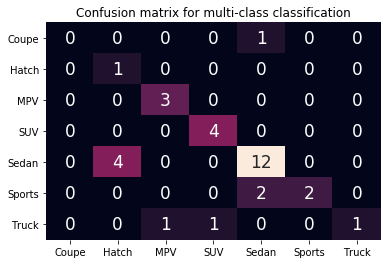

              precision    recall  f1-score   support

       Coupe       0.00      0.00      0.00         1
       Hatch       0.20      1.00      0.33         1
         MPV       0.75      1.00      0.86         3
         SUV       0.80      1.00      0.89         4
       Sedan       0.80      0.75      0.77        16
      Sports       1.00      0.50      0.67         4
       Truck       1.00      0.33      0.50         3

    accuracy                           0.72        32
   macro avg       0.65      0.65      0.57        32
weighted avg       0.80      0.72      0.72        32

The accuracy score is 71.88%


C:\Users\jiaxin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [42]:
#Making the confusion matrix
cm = confusion_matrix(y_test, y_pred)

#Visualise cm
sns.heatmap(cm, 
            annot=True,
            annot_kws={"size": 17},
            cbar=False,
           xticklabels=['Coupe','Hatch','MPV','SUV','Sedan','Sports','Truck'],
           yticklabels=['Coupe','Hatch','MPV','SUV','Sedan','Sports','Truck']) 

plt.title('Confusion matrix for multi-class classification')
plt.show()

print(classification_report(y_test,y_pred))
accuracy = accuracy_score(y_test,y_pred)
print(f'The accuracy score is {round(accuracy*100,2)}%')


### Evaluation 2 (based on decision tree visualisation and confusion matrix)

Based on the confusion matrix, it shows that there are 9 wrongfully predicted data.
The wrongfully predicted data are as follows:

In [43]:
#print wrong predictions
merge = list(zip(y_pred,y_test))
idx_counter = 0
idx = []
for elem in merge:
    if elem[0] != elem[1]:
        idx.append(idx_counter)
        print(f'index: {idx_counter}')
        print(f'Actual: {elem[1]}; Predicted: {elem[0]}')
    idx_counter += 1

index: 0
Actual: Sedan; Predicted: Hatch
index: 1
Actual: Truck; Predicted: SUV
index: 7
Actual: Sports; Predicted: Sedan
index: 13
Actual: Sports; Predicted: Sedan
index: 14
Actual: Sedan; Predicted: Hatch
index: 19
Actual: Sedan; Predicted: Hatch
index: 20
Actual: Sedan; Predicted: Hatch
index: 22
Actual: Truck; Predicted: MPV
index: 30
Actual: Coupe; Predicted: Sedan


Based on the confusion matrix, Coupe was wrongfully predicted once as Sedan. Aside from Hatch, MPV and SUV, the model has made some errors in remaining classes. We will take a closer analysis through the decision tree visualisation.

It can be seen that the algorithm tries to classify the vehicles by horsepower and wheelbase first. Vehicles with smaller horsepower might be classified as Sedan, Sports and Hatch. Meanwhile larger horsepower vehicles might be SUV, MPV or Truck. Based on this, we know that the algorithm first splits the vehicles into lighter weight vehicles and heavy weight vehicles.

To evaluate the accuracy of the model, the confusion matrix is shown to present some basic statistical data. The accuracy score of the model is 71.88%, which is lower than classification using ``Vehicle_class``. Aside from this, we see that the macro average scores are quite low. This is because macro average is calculated by computing the metric for each class independently, then the average is calculated. Looking at our dataset, there is a class imbalance where some classes have a lot more example than others. This is the reason why the macro average scores are lower, as macro average calculation treats all classes equally. 

Therefore, this model is not ideal,as it the imbalance of classes makes the model unable to fairly and correctly identify vehicles from *all* classes.

In [44]:
#Output to csv
prediction_csv = pd.DataFrame(y_pred, columns=['predictions'])
prediction_csv.index += 1
prediction_csv.to_csv('3e.multi_classification_prediction.csv', index_label='id')

---

# 4. Conclusion

## Multi-class classification (Random forest algorithm)
Multi-class classification using labelled data ``Vehicle_class`` is repeated using **random forest algorithm** to derive the best model.

In [45]:
x = df2.iloc[:,[5,6,7,8,9,10,11,12,13]].values #all numbered data
y = df2.iloc[:,2].values #labelled data: vehicle_class

x_train, x_test, y_train, y_test = train_test_split(x,y,
                                                    test_size=0.2,  
                                                   random_state=0)

#Feature scaling
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

#Fitting Random Forest Classification to the Training set
classifier4 = RandomForestClassifier(n_estimators = 20,
                                   criterion = 'entropy',
                                   random_state = 0
                                   )
classifier4.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

### Multi-class classifcation 3 visualisation
The classification that uses ``Vehicle_class`` as labelled data is visualised by plotting a tree.
Becuase random forest has multiple decision trees, we will be randomly selecting 3 for visualisation to get a rough idea how the random forest algorithm classified the vehicles.

[6, 12, 13]


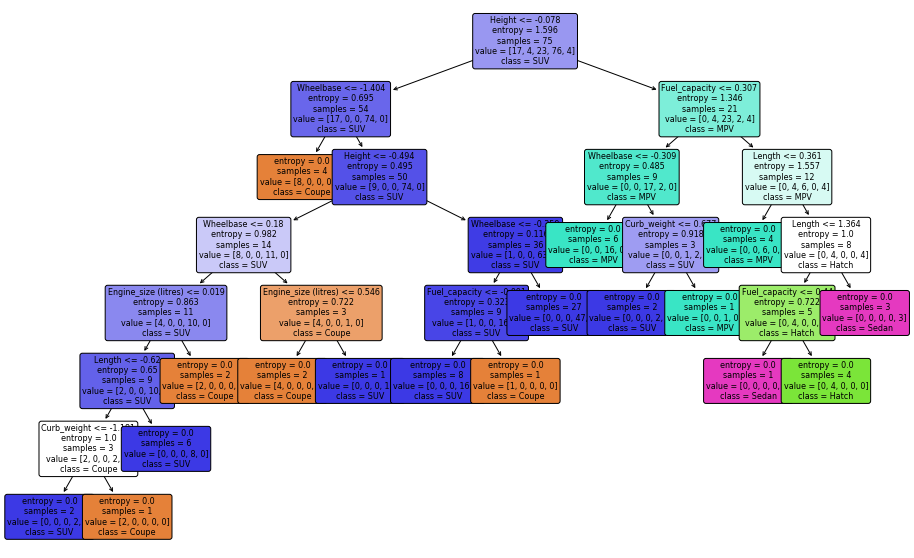

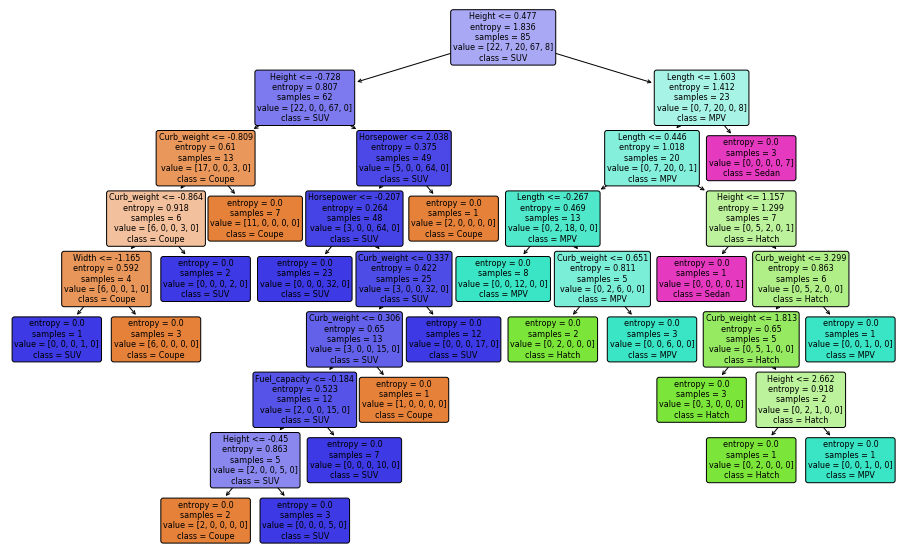

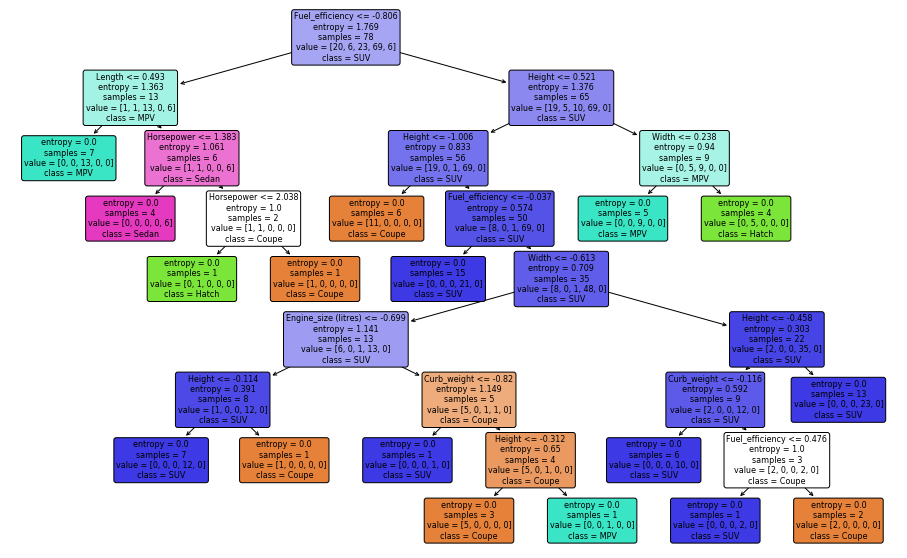

In [46]:
#pick random 3 trees from random forest
np.random.seed(1)
estimator_num = list(np.random.randint(low=1, high=20, size=3))
print(estimator_num)

#visualise the 3 trees
for i in estimator_num:
    plt.figure(figsize=(16,10))
    tree.plot_tree(classifier4.estimators_[i],
                   max_depth=None,
                   feature_names=feature_name,
                   class_names=class_name,
                   filled=True,
                   rounded=True,
                   fontsize=8
                  );

### Confusion matrix

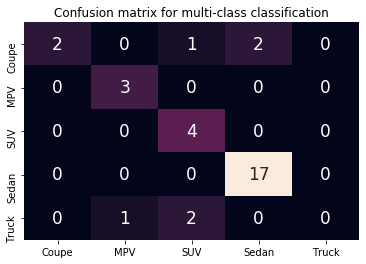

The accurary score is 81.25%


In [47]:
#Predicting the Test set results
y_pred = classifier4.predict(x_test)

#Making the cm
cm = confusion_matrix(y_test,y_pred)

#visualise cm
sns.heatmap(cm, 
            annot=True, 
            annot_kws={"size": 17},
            cbar=False,
            xticklabels=['Coupe','MPV','SUV','Sedan','Truck'],
            yticklabels=['Coupe','MPV','SUV','Sedan','Truck']) 
plt.title('Confusion matrix for multi-class classification')
plt.show()

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test,y_pred)
print(f'The accurary score is {round(accuracy*100,2)}%')

In [48]:
print(classification_report(y_test,y_pred))
accuracy = accuracy_score(y_test,y_pred)
print(f'The accuracy score is {round(accuracy*100,2)}%')

              precision    recall  f1-score   support

       Coupe       1.00      0.40      0.57         5
         MPV       0.75      1.00      0.86         3
         SUV       0.57      1.00      0.73         4
       Sedan       0.89      1.00      0.94        17
       Truck       0.00      0.00      0.00         3

    accuracy                           0.81        32
   macro avg       0.64      0.68      0.62        32
weighted avg       0.77      0.81      0.76        32

The accuracy score is 81.25%


C:\Users\jiaxin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Evaluation 3 (based on random forest visualisation and confusion matrix)

Based on the confusion matrix, there are 6 wrongfully predicted vehicles. The wrong predictions are as follows:

In [49]:
merge = list(zip(y_pred,y_test))
idx_counter = 0
idx = []
for elem in merge:
    if elem[0] != elem[1]:
        idx.append(idx_counter)
        print(f'index: {idx_counter}')
        print(f'Actual: {elem[1]}; Predicted: {elem[0]}')
    idx_counter += 1

index: 1
Actual: Truck; Predicted: MPV
index: 7
Actual: Coupe; Predicted: Sedan
index: 9
Actual: Truck; Predicted: SUV
index: 22
Actual: Truck; Predicted: SUV
index: 29
Actual: Coupe; Predicted: SUV
index: 30
Actual: Coupe; Predicted: Sedan


Comparing the output to the first multi-class classification attempt (using **decision tree algorithm**), there are exactly 4 same wrong predictions, which are vehicles with index 1, 7, 9 and 30 from the test data. For the differences, this model has predicted Truck and Coupe as SUV (index 22 and index 29); whereas the previous model predicted Coupe as Sedan and Truck as SUV (index 13 and 22).

Because the accuracy score for both models are 81.25%, we will be looking at the tree visualisation to determine the best model. We see that the 3 selected trees from random forest looks at the heavy-weight vehicles (such as SUV and MPV) first, compared to the decision tree algorithm that starts from the Sedan. Both ways do not affect the outcome drastically, as we see that the predictions are very similar.

Hence, we will go ahead with the latest classifier to predict the unknown kaggle dataset.



### Kaggle test data prediction

In [50]:
kaggle = pd.read_csv('FIT1043-kaggle-test-data.csv')
del kaggle['Id']
kaggle_test = sc.transform(kaggle)

kaggle_predict = classifier4.predict(kaggle_test)

counter = 0
for i in kaggle_predict:
    if counter == 0: print('Id Prediction')
    counter += 1
    print(counter, i)

Id Prediction
1 Sedan
2 Coupe
3 SUV
4 Coupe
5 MPV
6 Sedan
7 Sedan
8 Sedan
9 Coupe
10 SUV
11 SUV
12 SUV
13 Sedan
14 Sedan
15 Sedan
16 Sedan
17 SUV


In [51]:
#Output to csv
prediction_csv = pd.DataFrame(kaggle_predict, columns=['Predicted'])
prediction_csv.index += 1
prediction_csv.to_csv('prediction.csv', index_label='Id')

## Conclusion Paragraph

This assignment has provided some insight on how machine learning could be applied in real world data for data analysis. For unsupervised learning, clustering grouped vehicles with similar features together, and we were able to uncover some interesting data. Through clustering, we know that vehicles that are shorter have much more flexible power output, where there are small vehicles with huge power outputs, but also small vehicles with tiny power outputs; whereas tall and larger vehicles are usually fixed to have a certain range of power output.

The next section which focused on supervised learning was useful in predicting new unforeseen data. In this case, we were able to use decision tree algorithm to classify the vehicles into different classes. Running the best model obtained from the previous section through unknown data (the 17 vehicles from kaggle test data), the model was able to predict 16 out of 17 vehicles. This shows that supervised learning is very useful in performing classifications. In real world, this proves to be very useful as the model can predict a large amount of unlabelled data in a short amount of time. 

Therefore, machine learning which 'learns' and improve from experience can be very useful in Data Science if we use it efficiently by logically deciding on the parameters and criterias of the algorithm.